# Estimating $\alpha$ using GP-Optimization

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from gsmp_vglm import bayesian_optimization, plot_optimization_convergence
from gsmp_vglm.data_generation import GSMP_GLMData
from gsmp_vglm.grad_desc_sem_functions import GSMP_GLM

In [2]:
# Generate Data with known alpha, eta_vec and beta_vec
# Set parameters for the data generation process
n_obs = 2000
n_cov = 2
eta_vec = np.array([1.0, 0.5, -0.25])
beta_vec = np.array([2.0, -2.0, 1.0])
alpha = 0.1

print("Generating data...")
# Generate synthetic data
data_gen = GSMP_GLMData(
    dist_type = 'uniform',
    alpha = alpha,
    n_obs=n_obs, 
    n_cov=n_cov, 
    add_intercept=True, 
    eta_vec=eta_vec, 
    beta_vec=beta_vec
)

# Resulting outputs
X, Y, N, W, Z = data_gen.make_data()

Generating data...


In [3]:
# Define optimization hyperparameter dictionary
hyperparams_dict = {'learning_rate': 0.0001,             # Learning rate, aka "step size"
                    'sgd_iter': 100,                     # Number of gradient descent steps
                    'init_multiplier': 0.999,            # Step size decay function
                    'initial_alpha': 0.3 ,               # What value should the optimization start with
                    'n_calls': 30,                       # How many optimization steps should be taken
                    'alpha_bounds': (0.000001, 0.3)      # Bounds for the function to explore
                   }

In [4]:
# Create a data dictionary to pass through into the optimizer
#  currently function expects a dataframe, so it is converted first
data_dict = {
    'X': pd.Series(X),
    'N': pd.Series(N),
    'W': pd.DataFrame(W),
    'Z': pd.DataFrame(Z)
}

In [5]:
# Initialize the model
gsmp_glm = GSMP_GLM()

In [6]:
# Run the Optimizer
result = bayesian_optimization(data_dict, hyperparams_dict['initial_alpha'], hyperparams_dict['learning_rate'], 
                               hyperparams_dict['sgd_iter'], hyperparams_dict['init_multiplier'], 
                               n_calls = hyperparams_dict['n_calls'], alpha_bounds = hyperparams_dict['alpha_bounds'])

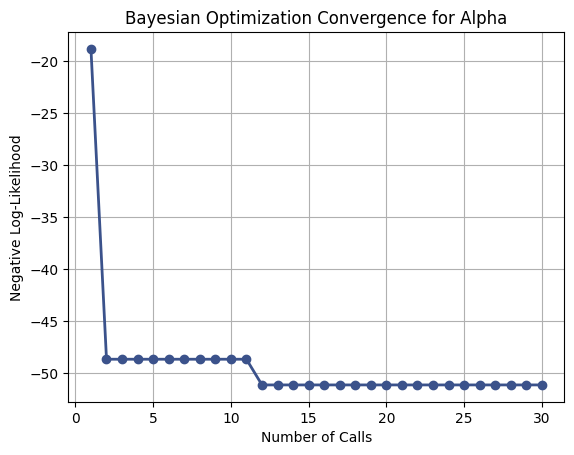

In [7]:
# View Convergence related procedures
plot_optimization_convergence(result)
plt.show()

The best alpha was 0.1032, compared to the real value of 0.1


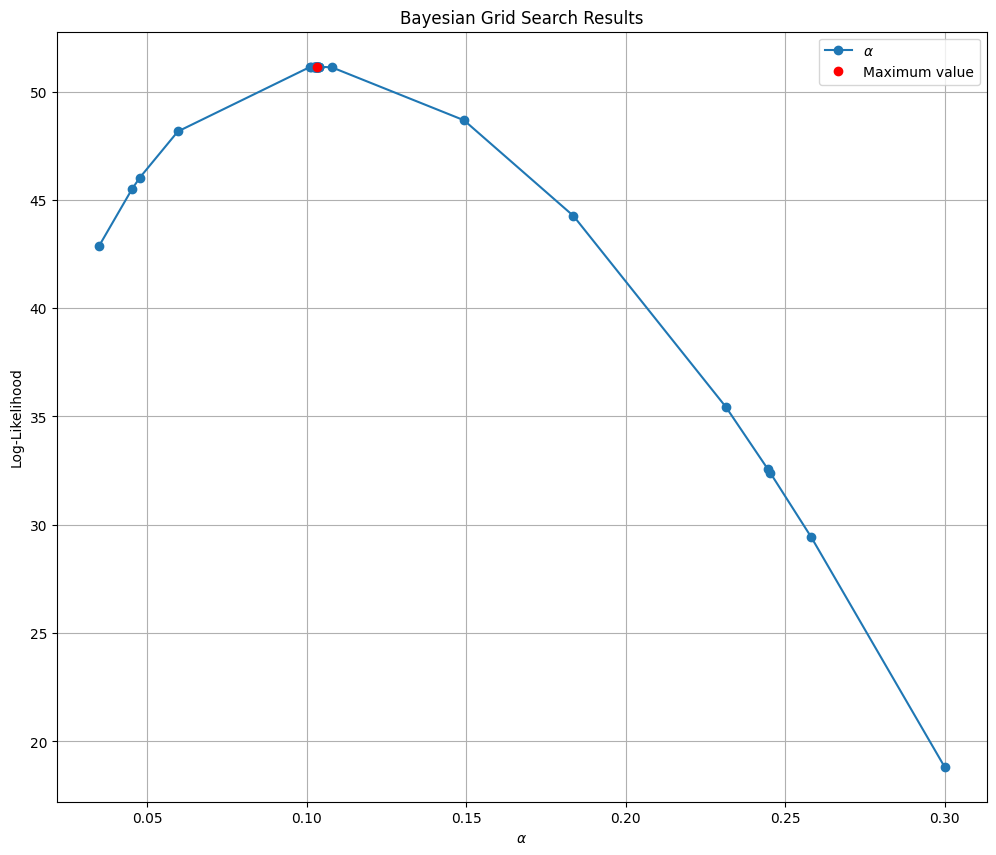

In [8]:
# Create Optimization plot

# storing alphas and associated log-likelihoods
tested_alphas = np.array(result.x_iters)
loglikes = np.array([-r for r in result.func_vals])  # Convert back to positive log-likelihood

# return sorted values of alpha indicies
sorted_indices = np.argsort(tested_alphas[:, 0])

# sort `tested_alphas` and `loglikes` using the sorted indices
sorted_alphas = tested_alphas[sorted_indices]
sorted_loglikes = loglikes[sorted_indices]

# finding optimal value
max_index = np.argmax(sorted_loglikes)
best_alpha = sorted_alphas[max_index]
best_llike = sorted_loglikes[max_index]

print(f'The best alpha was {best_alpha[0]:.4f}, compared to the real value of {alpha}')

# make the plot
plt.figure(figsize = (12, 10))
plt.plot(sorted_alphas, sorted_loglikes, 'o-', label = rf'$\alpha$')
plt.plot(best_alpha, best_llike, 'ro', label = 'Maximum value')
plt.xlabel(r'$\alpha$')
plt.ylabel('Log-Likelihood')
plt.title('Bayesian Grid Search Results')
plt.legend()
plt.grid(True)

plt.show()